<a href="https://colab.research.google.com/github/NehaSontakk/BATH-Prokka-Comparison/blob/main/Annotation_Name_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install gffpandas
!sudo apt-get install bedops
!pip install biopython

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
bedops is already the newest version (2.4.40+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [23]:
bath_prokka_aligned_annotations = "/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Aligned Outputs/Aligned_Outputs_bin152.xlsx"
annotation_match_storage = "/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Alignment_Overlaps_Unique_Bedmap_COGs_bin152.xlsx"

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import gffpandas.gffpandas as gffpd
from Bio import SeqIO
import requests
import re

In [25]:
alignments = pd.read_excel(bath_prokka_aligned_annotations)

Filter dataset to just the annotations that align to each other

In [26]:
alignment_overlaps = alignments[alignments['label']=="BATH and Prokka Annotated"]

### Annotation label comparison

In [27]:
alignment_overlaps['Annotation_Match'] = 'No'

for index, row in alignment_overlaps.iterrows():
    prokka_protein = ""
    bath_protein = ""
    if row['label'] == "BATH and Prokka Annotated":
        prokka_protein = row['Prokka'].split(":")[-1]
        bath_protein = row['BATH'].split("\t")[-3]
        if prokka_protein == bath_protein:
            alignment_overlaps.loc[index, 'Annotation_Match'] = 'Yes'

<ipython-input-27-357b807f7606>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alignment_overlaps['Annotation_Match'] = 'No'


Do the annotation labels match?

In [28]:
alignment_overlaps['Annotation_Match'].value_counts()

,count
Annotation_Match,
No,168
Yes,108


### COG Level Overlap

In [29]:
#Retrieve the right COGs for each dataframe
def get_eggnog_link(protein_name):
  if protein_name != "":
    url = f"https://rest.uniprot.org/uniprotkb/search?query={protein_name}&format=json"
    #print(url)
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        #print(data.get(""))
        for result in data.get('results', []):
            #print(result)
            cross_refs = result.get("uniProtKBCrossReferences", [])
            #print(cross_refs)
            for ref in cross_refs:
                if ref.get('database') == 'eggNOG':
                    return ref.get('id')
    except requests.RequestException as e:
        print(f"Request failed: {e}")
  else:
    return None


### !Uncomment if you are doing a new set

In [30]:
alignment_overlaps['Prokka COGs'] = alignment_overlaps['Prokka'].apply(lambda x: get_eggnog_link(x.split(":")[-1]))

<ipython-input-30-610285e70e5d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alignment_overlaps['Prokka COGs'] = alignment_overlaps['Prokka'].apply(lambda x: get_eggnog_link(x.split(":")[-1]))


In [31]:
alignment_overlaps['BATH']

,BATH
87,k127_2253129\t901\t2262\tQ99SX1\t+\t0
90,k127_2253129\t11353\t11787\tO35016\t+\t0
91,k127_2033476\t541\t1671\tP80092\t+\t0
92,k127_2033476\t3426\t3785\tMF_00101\t+\t0
93,k127_2033476\t3829\t5298\tQ9X024\t+\t0
...,...
378,k127_2982141\t9733\t11265\tMF_00139\t+\t0
379,k127_2982141\t11286\t12548\tMF_00138\t+\t0
380,k127_2982141\t12931\t13911\tA3DDX7\t+\t0
382,k127_2982141\t16989\t17780\tMF_00228\t+\t0


In [32]:
#Hasn't been working well
alignment_overlaps['BATH COGs'] = alignment_overlaps['BATH'].apply(lambda x: get_eggnog_link(x.split('\t')[-3]))

<ipython-input-32-e625b6ba122f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alignment_overlaps['BATH COGs'] = alignment_overlaps['BATH'].apply(lambda x: get_eggnog_link(x.split('\t')[-3]))


In [33]:
def get_eggnog_link(protein_name):
    if protein_name != "":
        url = f"https://rest.uniprot.org/uniprotkb/search?query={protein_name}&format=json"
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            for result in data.get('results', []):
                cross_refs = result.get("uniProtKBCrossReferences", [])
                for ref in cross_refs:
                    if ref.get('database') == 'eggNOG':
                        return ref.get('id')
        except requests.RequestException as e:
            print(f"Request failed: {e}")
    return None

def debug_split(x):
    parts = re.split(r'\s+', x)  # This uses regular expressions to split by any whitespace
    print(parts)  # This will print the split results
    if len(parts) >= 3:
        return get_eggnog_link(parts[-3])
    else:
        print(f"Not enough parts in the list: {parts}")  # Optional: Print an error or warning
        return None

alignment_overlaps['BATH COGs'] = alignment_overlaps['BATH'].apply(debug_split)


['k127_2253129', '901', '2262', 'Q99SX1', '+', '0']
['k127_2253129', '11353', '11787', 'O35016', '+', '0']
['k127_2033476', '541', '1671', 'P80092', '+', '0']
['k127_2033476', '3426', '3785', 'MF_00101', '+', '0']
['k127_2033476', '3829', '5298', 'Q9X024', '+', '0']
['k127_2033476', '8477', '9502', 'P75830', '+', '0']
['k127_2033476', '9604', '11480', 'Q5MK06', '+', '1']
['k127_2033476', '9604', '11480', 'Q5MK06', '+', '1']
['k127_2033476', '11779', '12999', 'MF_01642', '+', '0']
['k127_2033476', '13107', '14201', 'MF_00944', '+', '0']
['k127_2033476', '14261', '14857', 'MF_00095', '+', '0']
['k127_2033476', '17001', '17663', 'Q9KJN4', '+', '0']
['k127_2033476', '17671', '18204', 'MF_01469', '+', '0']
['k127_2033476', '18255', '19061', 'MF_00607', '+', '0']
['k127_2033476', '19638', '20903', 'MF_00176', '+', '0']
['k127_2033476', '23266', '24225', 'MF_01562', '+', '0']
['k127_2033476', '26037', '26870', 'MF_01425', '+', '0']
['k127_2033476', '27654', '28553', 'Q06754', '+', '0']
['k127

<ipython-input-33-302fa5ab4a5a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alignment_overlaps['BATH COGs'] = alignment_overlaps['BATH'].apply(debug_split)


In [34]:
alignment_overlaps.to_excel(annotation_match_storage)

## PART 2

In [35]:
alignment_overlaps = pd.read_excel(annotation_match_storage)

In [36]:
alignment_overlaps['Name_or_COG_Match'] = 'No'

for index, row in alignment_overlaps.iterrows():
    prokka_COG = row['Prokka COGs']
    bath_COG = row['BATH COGs']
    prokka_protein = row['Prokka'].split(":")[-1]
    bath_parts = re.split(r'\s+', row['BATH'])
    if len(bath_parts) >= 3:
        bath_protein = bath_parts[-3]
        if (prokka_COG == bath_COG) or (prokka_protein == bath_protein):
            alignment_overlaps.loc[index, 'Name_or_COG_Match'] = 'Yes'
    else:
        print(f"Not enough parts in the list for index {index}: {bath_parts}")


In [37]:
alignment_overlaps['Name_or_COG_Match'].value_counts()

,count
Name_or_COG_Match,
Yes,172
No,104


In [38]:
#How many because there are no annotations?

print(alignment_overlaps[(alignment_overlaps['Name_or_COG_Match'] == "No") & (alignment_overlaps['Prokka COGs'].isna()) & (alignment_overlaps['BATH COGs'].isna())].shape[0])

bath_none_count = alignment_overlaps[(alignment_overlaps['Name_or_COG_Match'] == "No") & (alignment_overlaps['BATH COGs'].isna())].shape[0]

prokka_none_count = alignment_overlaps[(alignment_overlaps['Name_or_COG_Match'] == "No") & (alignment_overlaps['Prokka COGs'].isna())].shape[0]

print(f"Number of rows with 'Name_or_COG_Match' == 'No' and no 'BATH COGs': {bath_none_count}")
print(f"Number of rows with 'Name_or_COG_Match' == 'No' and no 'Prokka COGs': {prokka_none_count}")


3
Number of rows with 'Name_or_COG_Match' == 'No' and no 'BATH COGs': 9
Number of rows with 'Name_or_COG_Match' == 'No' and no 'Prokka COGs': 55


In [39]:
alignment_overlaps[(alignment_overlaps['Name_or_COG_Match'] == "No") & (alignment_overlaps['Prokka COGs'].isna())]['Name_or_COG_Match'] = np.nan
alignment_overlaps[(alignment_overlaps['Name_or_COG_Match'] == "No") & (alignment_overlaps['BATH COGs'].isna())]['Name_or_COG_Match'] = np.nan
alignment_overlaps[(alignment_overlaps['Name_or_COG_Match'] == "No") & (alignment_overlaps['Prokka COGs'].isna()) & (alignment_overlaps['BATH COGs'].isna())]['Name_or_COG_Match'] = np.nan

<ipython-input-39-058bdaf21779>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alignment_overlaps[(alignment_overlaps['Name_or_COG_Match'] == "No") & (alignment_overlaps['Prokka COGs'].isna())]['Name_or_COG_Match'] = np.nan
<ipython-input-39-058bdaf21779>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alignment_overlaps[(alignment_overlaps['Name_or_COG_Match'] == "No") & (alignment_overlaps['BATH COGs'].isna())]['Name_or_COG_Match'] = np.nan
<ipython-input-39-058bdaf21779>:3: SettingWithCopyWarning: 
A 

In [40]:
!pip install squarify

In [41]:
match_annotations = alignment_overlaps[(alignment_overlaps['Name_or_COG_Match'] == 'Yes')].shape[0]
mismatch_annotations = alignment_overlaps[(alignment_overlaps['Name_or_COG_Match'] == 'No') & (~alignment_overlaps['Prokka COGs'].isna()) & (~alignment_overlaps['BATH COGs'].isna())].shape[0]
missing_both = alignment_overlaps[(alignment_overlaps['Prokka COGs'].isna()) & (alignment_overlaps['BATH COGs'].isna())].shape[0]
missing_cogs_bath = alignment_overlaps[(alignment_overlaps['BATH COGs'].isna()) & (~alignment_overlaps['Prokka COGs'].isna())].shape[0]
missing_cogs_prokka = alignment_overlaps[(alignment_overlaps['Prokka COGs'].isna()) & (~alignment_overlaps['BATH COGs'].isna())].shape[0]


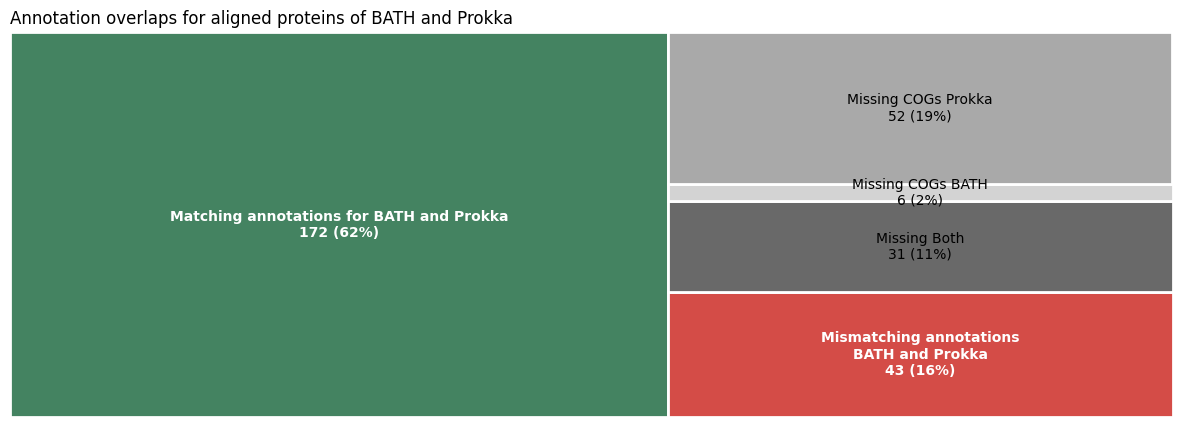

In [42]:
import matplotlib.pyplot as plt
import squarify

# Data
total = alignment_overlaps.shape[0]
categories = [
    'Matching annotations for BATH and Prokka',
    'Mismatching annotations\nBATH and Prokka',
    'Missing Both',
    'Missing COGs BATH',
    'Missing COGs Prokka'
]
values = [match_annotations, mismatch_annotations, missing_both, missing_cogs_bath, missing_cogs_prokka]

# Calculate percentages
percentages = [value / total * 100 for value in values]

# Create labels with percentages
labels = [f'{cat}\n{val} ({perc:.0f}%)' for cat, val, perc in zip(categories, values, percentages)]

# Plot the treemap
plt.figure(figsize=(15, 5))
colors = ['#448361', '#D44C47', '#696969', '#D3D3D3', '#A9A9A9']
squarify.plot(sizes=values, label=labels, color=colors, edgecolor="white", linewidth=2)

# Customize text colors and make the first two labels bold and white
for i in range(len(labels)):
    text = plt.gca().texts[i]
    if i < 2:  # First two categories
        text.set_color('white')
        text.set_fontweight('bold')

plt.title('Annotation overlaps for aligned proteins of BATH and Prokka', loc='left')
plt.axis('off')  # Hide axes
plt.savefig("Fig5A_annotations_name.svg", dpi=300, transparent=True, bbox_inches='tight')
plt.show()


In [43]:
alignment_overlaps.to_excel(annotation_match_storage, index=False)

In [44]:
alignment_overlaps = pd.read_excel(annotation_match_storage)

     Unnamed: 0                                             Prokka  \
0            87  k127_2253129\t895\t2301\tJNLINIBG_00430\t+\tab...   
1            90  k127_2253129\t11320\t11796\tJNLINIBG_00436\t+\...   
2            91  k127_2033476\t517\t1767\tJNLINIBG_00225\t+\tab...   
3            92  k127_2033476\t3423\t3815\tJNLINIBG_00228\t+\ta...   
4            93  k127_2033476\t3796\t5328\tJNLINIBG_00229\t+\ta...   
..          ...                                                ...   
271         378  k127_2982141\t9727\t11271\tJNLINIBG_00634\t+\t...   
272         379  k127_2982141\t11286\t12566\tJNLINIBG_00635\t+\...   
273         380  k127_2982141\t12928\t13914\tJNLINIBG_00636\t+\...   
274         382  k127_2982141\t16983\t17789\tJNLINIBG_00640\t+\...   
275         383  k127_2982141\t17776\t18411\tJNLINIBG_00641\t+\...   

                                           BATH                      label  \
0         k127_2253129\t901\t2262\tQ99SX1\t+\t0  BATH and Prokka Annotated   
1  

<ipython-input-45-937abea8e243>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Name_or_COG_Match', y='Shifts', data=alignment_overlaps, palette="Set2")


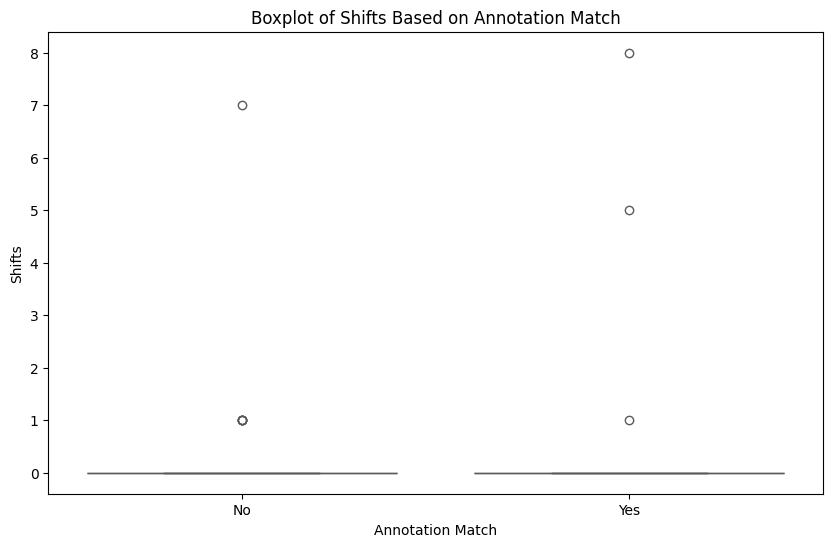

In [45]:
alignment_overlaps['Shifts'] = alignment_overlaps['BATH'].apply(lambda x: int(x.split('\t')[-1]))

# Display the DataFrame to verify the new column
print(alignment_overlaps)

# Plotting the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Name_or_COG_Match', y='Shifts', data=alignment_overlaps, palette="Set2")

# Add title and labels
plt.title('Boxplot of Shifts Based on Annotation Match')
plt.xlabel('Annotation Match')
plt.ylabel('Shifts')

# Display the plot
plt.show()

### Alignment length for overlaping annotations and names

In [46]:
filter1_alignments = alignments.dropna()

In [47]:
alignment_overlaps.loc[alignment_overlaps['Name_or_COG_Match'] == 'Yes']

,Unnamed: 0,Prokka,BATH,label,Annotation_Match,Prokka COGs,BATH COGs,Name_or_COG_Match,Shifts
1,90,k127_2253129\t11320\t11796\tJNLINIBG_00436\t+\...,k127_2253129\t11353\t11787\tO35016\t+\t0,BATH and Prokka Annotated,Yes,COG0394,COG0394,Yes,0
3,92,k127_2033476\t3423\t3815\tJNLINIBG_00228\t+\ta...,k127_2033476\t3426\t3785\tMF_00101\t+\t0,BATH and Prokka Annotated,No,COG0736,COG0736,Yes,0
4,93,k127_2033476\t3796\t5328\tJNLINIBG_00229\t+\ta...,k127_2033476\t3829\t5298\tQ9X024\t+\t0,BATH and Prokka Annotated,Yes,COG0062,COG0062,Yes,0
5,95,k127_2033476\t8474\t9571\tJNLINIBG_00234\t+\ta...,k127_2033476\t8477\t9502\tP75830\t+\t0,BATH and Prokka Annotated,Yes,COG0845,COG0845,Yes,0
7,97,k127_2033476\t10278\t11492\tJNLINIBG_00236\t+\...,k127_2033476\t9604\t11480\tQ5MK06\t+\t1,BATH and Prokka Annotated,Yes,NaN,NaN,Yes,1
...,...,...,...,...,...,...,...,...,...
266,373,k127_2982141\t5028\t5519\tJNLINIBG_00629\t+\ta...,k127_2982141\t5028\t5504\tMF_01929\t+\t0,BATH and Prokka Annotated,No,COG0041,COG0041,Yes,0
267,374,k127_2982141\t5592\t6455\tJNLINIBG_00630\t+\ta...,k127_2982141\t5586\t6452\tP9WHN1\t+\t0,BATH and Prokka Annotated,Yes,COG0152,COG0152,Yes,0
268,375,k127_2982141\t6571\t7992\tJNLINIBG_00631\t+\ta...,k127_2982141\t6601\t7959\tMF_01931\t+\t0,BATH and Prokka Annotated,No,COG0034,COG0034,Yes,0
273,380,k127_2982141\t12928\t13914\tJNLINIBG_00636\t+\...,k127_2982141\t12931\t13911\tA3DDX7\t+\t0,BATH and Prokka Annotated,Yes,COG1748,COG1748,Yes,0


In [48]:
def get_alignment_lengths_with_colors(df):
    index = []
    prokka_alignment_size = []
    bath_alignment_size = []
    colors = []

    for i, r in df.iterrows():
        color = "blue"
        prokka_row_list = r['Prokka'].split("\t")
        if len(prokka_row_list) >= 3:
            prokka_size = abs(int(prokka_row_list[1]) - int(prokka_row_list[2]))
            prokka_alignment_size.append(prokka_size)
            index.append(i)
            if "UniProtKB" in r['Prokka']:
                color = "grey"
            elif "HAMAP" in r['Prokka']:
                color = "green"
            elif "ISfinder" in r['Prokka']:
                color = "red"

        else:
            print(f"Skipping row {i} due to insufficient elements in 'Prokka'. Prokka content: {r['Prokka']}")
            continue

        bath_row_list = r['BATH'].split("\t")
        if len(bath_row_list) >= 3:
            bath_size = abs(int(bath_row_list[1]) - int(bath_row_list[2]))
            bath_alignment_size.append(bath_size)
        else:
            bath_alignment_size.append(None)
            print(f"Skipping BATH part of row {i} due to insufficient elements. BATH content: {r['BATH']}")
        colors.append(color)

    assert len(prokka_alignment_size) == len(bath_alignment_size) == len(colors), "List sizes do not match."

    return prokka_alignment_size, bath_alignment_size, colors


prokka_alignsize, bath_alignsize, colors = get_alignment_lengths_with_colors(alignment_overlaps.loc[alignment_overlaps['Name_or_COG_Match'] == 'Yes'])

<ipython-input-49-68f36916685c>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


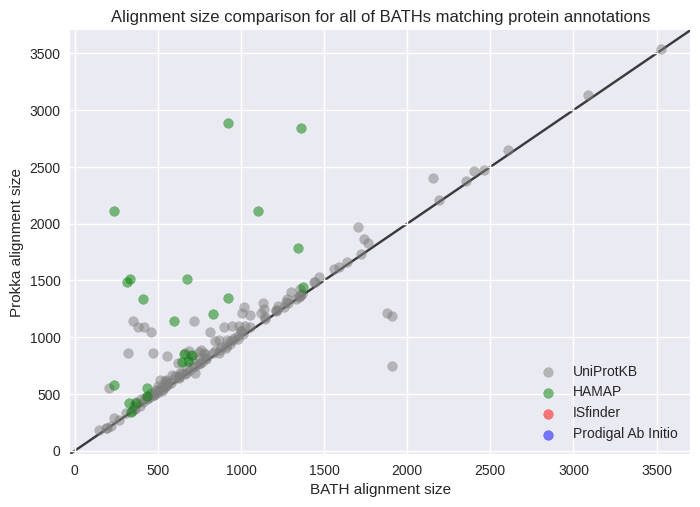

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use("seaborn")

categories = ['UniProtKB', 'HAMAP', 'ISfinder', 'Others']
colors_map = {'UniProtKB': 'grey', 'HAMAP': 'green', 'ISfinder': 'red', 'Prodigal Ab Initio': 'blue'}

for category, color in colors_map.items():
    mask = np.array(colors) == color
    plt.scatter(np.array(bath_alignsize)[mask], np.array(prokka_alignsize)[mask], color=color, alpha=0.5, label=category)

plt.xlabel('BATH alignment size')
plt.ylabel('Prokka alignment size')
plt.title('Alignment size comparison for all of BATHs matching protein annotations')

lims = [
    np.min([plt.gca().get_xlim(), plt.gca().get_ylim()]),
    np.max([plt.gca().get_xlim(), plt.gca().get_ylim()]),
]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
plt.show()

In [50]:
import pandas as pd
data = pd.read_excel("/content/drive/MyDrive/Lab Work/Parkinsons_Data/Organized/Alignment_Overlaps_Unique_Bedmap_COG_Matches.xlsx")

In [51]:
data

,Unnamed: 0.1,Unnamed: 0,Prokka,BATH,label,Annotation_Match,Prokka COGs,BATH COGs,Name_or_COG_Match
0,0,87,k127_2253129\t895\t2301\tJNLINIBG_00430\t+\tab...,k127_2253129\t901\t2262\tQ99SX1\t+\t0,BATH and Prokka Annotated,No,NaN,NaN,No
1,1,90,k127_2253129\t11320\t11796\tJNLINIBG_00436\t+\...,k127_2253129\t11353\t11787\tO35016\t+\t0,BATH and Prokka Annotated,Yes,COG0394,COG0394,Yes
2,2,91,k127_2033476\t517\t1767\tJNLINIBG_00225\t+\tab...,k127_2033476\t541\t1671\tP80092\t+\t0,BATH and Prokka Annotated,No,COG1473,arCOG01108,No
3,3,92,k127_2033476\t3423\t3815\tJNLINIBG_00228\t+\ta...,k127_2033476\t3426\t3785\tMF_00101\t+\t0,BATH and Prokka Annotated,No,COG0736,COG0736,Yes
4,4,93,k127_2033476\t3796\t5328\tJNLINIBG_00229\t+\ta...,k127_2033476\t3829\t5298\tQ9X024\t+\t0,BATH and Prokka Annotated,Yes,COG0062,COG0062,Yes
...,...,...,...,...,...,...,...,...,...
271,271,378,k127_2982141\t9727\t11271\tJNLINIBG_00634\t+\t...,k127_2982141\t9733\t11265\tMF_00139\t+\t0,BATH and Prokka Annotated,No,NaN,KOG2555,No
272,272,379,k127_2982141\t11286\t12566\tJNLINIBG_00635\t+\...,k127_2982141\t11286\t12548\tMF_00138\t+\t0,BATH and Prokka Annotated,No,COG0151,KOG0237,No
273,273,380,k127_2982141\t12928\t13914\tJNLINIBG_00636\t+\...,k127_2982141\t12931\t13911\tA3DDX7\t+\t0,BATH and Prokka Annotated,Yes,COG1748,COG1748,Yes
274,274,382,k127_2982141\t16983\t17789\tJNLINIBG_00640\t+\...,k127_2982141\t16989\t17780\tMF_00228\t+\t0,BATH and Prokka Annotated,No,COG2145,COG2145,Yes


In [52]:
prokka_alignsize, bath_alignsize, colors = get_alignment_lengths_with_colors(alignment_overlaps.loc[alignment_overlaps['Name_or_COG_Match'] == 'Yes'])

In [53]:
len(prokka_alignsize)

172

In [54]:
alignment_overlaps[alignment_overlaps['Name_or_COG_Match'] == 'Yes']['Prokka alignsize'] = prokka_alignsize
alignment_overlaps[alignment_overlaps['Name_or_COG_Match'] == 'Yes']['BATH alignsize'] = bath_alignsize

<ipython-input-54-2983f331bc29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alignment_overlaps[alignment_overlaps['Name_or_COG_Match'] == 'Yes']['Prokka alignsize'] = prokka_alignsize
<ipython-input-54-2983f331bc29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alignment_overlaps[alignment_overlaps['Name_or_COG_Match'] == 'Yes']['BATH alignsize'] = bath_alignsize


In [55]:
# First, ensure your index list matches the filtered DataFrame's index where 'Name_or_COG_Match' is 'Yes'
filtered_index = alignment_overlaps[alignment_overlaps['Name_or_COG_Match'] == 'Yes'].index

# Assign 'prokka_alignsize' and 'bath_alignsize' using .loc on the filtered index
alignment_overlaps.loc[filtered_index, 'Prokka alignsize'] = prokka_alignsize
alignment_overlaps.loc[filtered_index, 'BATH alignsize'] = bath_alignsize


In [56]:
alignment_overlaps.sort_values('Prokka alignsize',ascending=False).to_excel("Size.xlsx")